# The purpose of this notebook is to familiarize yourself with some of the helpful functions in the SnI (Susceptible n-Infected) class



In [1]:
#allows plots in notebook
%matplotlib inline
#sets notebook figures to high quality svg
%config InlineBackend.figure_format = 'svg'

import pandas as pd
import numpy as np
from src.ModelFrameworks import SnI
import matplotlib.pyplot as plt

#ignore warnings to avoid flooding notebook output
import warnings
warnings.filterwarnings('ignore')

#Lets the notebook transition to R  easily!
%load_ext rpy2.ipython

## Data Import
The SnI class must be provided with a dataframe indexed correctly with the correct data. Bellow, we will import some an example

In [2]:
df = pd.read_csv('data/testdat.csv')
df = df.set_index('organism')
df

,time,abundance,uncertainty
organism,,,
virus,0.0,10981000.0,656690.00
virus,0.2,12959000.0,2987300.00
virus,0.3,13273000.0,3480600.00
virus,0.5,17914000.0,3981250.00
virus,0.7,15899000.0,4815700.00
virus,0.9,13881000.0,3985500.00
virus,0.9,15545000.0,3491900.00
virus,1.0,14527000.0,5474350.00
virus,1.2,12516000.0,6314200.00


As you can see, data is indexted by the organsim and identified as either virus or host. The other pieces of data included are time, the abundance at that time, and the uncertainty. Now that we have our data, lets initialize an instance of the SnI class

In [3]:
#initialize model framework
modframe = SnI(df,Infection_states=0)
modframe

Number of Infection States = 0
Parameters:
	mu = 1e-06
	phi = 1e-08
	beta = 25

Notice that we need to specify the number of infection states. SnI is smart enought to know what parameters are needed depending on the infection state and if you do not provide parameters it will assign default values. We can use the plot() function to visualize the fit

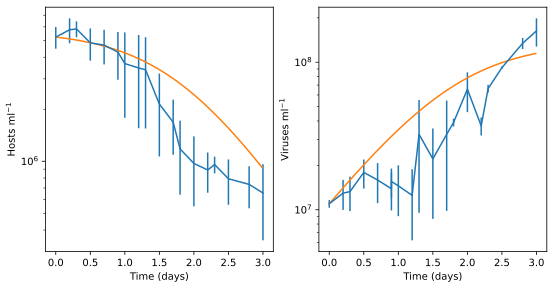

In [4]:
f,ax=modframe.plot()

Not a bad fits for defaults! But lets see what it looks like when we change the number of infection states by accessing the attribute Istates

Number of Infection States = 1
Parameters:
	mu = 1e-06
	phi = 1e-08
	beta = 25
	lam = 1


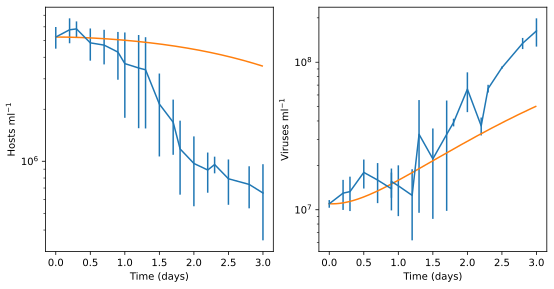

In [5]:
modframe.Istates=1
print(modframe)
f,ax=modframe.plot()

As you can see, *lam* is now included in the parameters with the default value. What you can also see is that the initial parameters are so egregious, euler integration produced negative numbers (which we define as a failure). Luckily, we can search for some initial values using a latin hypercube sampling scheme. Using search_inits(), we will take 100,000 samples using the priors we provide for each parameter, which are assumed to be a normal distribution with the lower bound > 0. Priors are specified by passing a tupple with the mean,standard deviation, and a boolean indicating a tinylog transfromation (please, if there is a actual name for this type of transformation, let me know). The tinylog transformation places the mean at $10^{-\mu}$ and the standard deviation spans log space, making the sampling ideal for very small values (such as $\mu$ or $\phi$).If a parameter is not provided with a prior, all samples will include the default parameters.

Lets search for initial values. Note, this process supports muliple cores!

Sampling with a Latin Hypercube scheme
Starting 100000 processes with 8 cores	[DONE]
count    81368.000000
mean       134.640724
std         87.567210
min         10.179446
25%         85.679899
50%        150.569698
75%        152.825112
max       1804.863485
Name: chi, dtype: float64


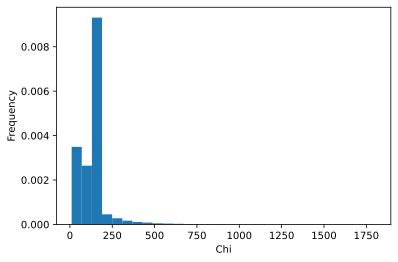

In [6]:
#Remember, search_inits is hardcoded to only sample positive numbers!
mu_prior = (6,3,True) # mean: 10^-6, mean - std: 10^-10, mean + std: 10^-2
phi_prior = (8,4,True)
beta_prior = (30,15,False)# normal distribution, mean = 30, sigma = 15.
lam_prior = (1,1,False)
inits=modframe.search_inits(samples=100000,cpu_cores=8,
                            mu=mu_prior,
                            phi=phi_prior,
                            beta=beta_prior,
                            lam=lam_prior
                           )
#lets plot the chi
a=inits['chi'].plot.hist(bins=30,density=True)
a.set_xlabel('Chi')
print(inits['chi'].describe())

We just ran 100,000 simulations searching for good initials. There are two things you should realize:
1. The inits dataframe had less than 100,000 rows of parameters
2. There are some **very** bad fits ( chi >150), but also some good fits

The reason why we didn't get 100,000 parameter sets is because some would cause the Euler integration to fail. However, that is to be expected. If you are not getting any good fits from the initial parameter search, you likely have to relax your constrains on your priors.

Now that we have some nice priors, lets sub-sample 20 parameters sets. We will restrict this sub sampling to better chis, guaranteeing us to get decent initial parameters to initialize our markov chains. To launch the MCMC analysis, we use the function MCMC and pass our initial values

In [7]:
#Getting 20 draws of inits with good-ish chis!
MCMC_inits = inits[inits['chi'] < 140].sample(20)
print(MCMC_inits)
#Launching 20 markov chains, 10,000 iterations each
#median values are set as new parameters for the modframe
posteriors = modframe.MCMC(chain_inits = MCMC_inits,iterations=10000,cpu_cores=8)
posteriors

                 mu           phi       beta       lam         chi
66698  3.053776e-04  6.464706e-09  42.582117  2.028853   36.836368
54416  2.699022e-11  3.507190e-07  41.738760  0.421542   49.953120
65866  4.982734e-01  2.569571e-07   3.778152  0.492572   75.456889
57389  1.928936e-12  3.848839e-05  18.964131  0.538645   23.714520
58804  1.055057e-05  2.127062e-08  36.893341  2.121654   38.626036
85094  8.537843e-07  2.383758e-08  36.084904  0.592917   30.070324
53647  8.586547e-07  1.439536e-09  27.402563  0.922819  125.967177
65070  2.650057e-08  8.885136e-09  30.154426  0.266460   97.034012
95604  3.903535e-12  7.307980e-09  37.539997  1.286634   43.629457
81116  3.088642e-08  6.584183e-10  53.787012  2.130773  119.785149
58244  7.522811e-06  4.307954e-07  33.765981  0.405487   38.270392
528    2.149194e-09  8.045386e-09  37.466311  0.656969   58.196395
4026   4.821099e-08  1.001396e-07  34.060395  0.128665   52.418105
5678   1.364061e-09  2.902186e-02  14.645221  1.585931  112.19

,mu,phi,beta,lam,chi,adjR2,Iteration,chain#
0,1.033955e-03,5.620108e-08,9.776432,1.568937,13.315442,0.277983,5001.0,0
1,1.092752e-03,5.687426e-08,10.869655,1.574320,11.970707,0.361610,5003.0,0
2,1.159275e-03,6.330707e-08,10.456643,1.495343,12.498977,0.334511,5004.0,0
3,1.111803e-03,6.537069e-08,10.446769,1.478834,12.612532,0.334350,5005.0,0
4,1.134582e-03,6.927455e-08,11.165413,1.426583,12.291386,0.377883,5008.0,0
...,...,...,...,...,...,...,...,...
66515,1.046145e-09,5.127287e-08,11.429854,1.698573,11.622699,0.397846,9992.0,19
66516,9.747539e-10,5.036548e-08,11.751273,1.651104,11.177492,0.413533,9993.0,19
66517,9.565136e-10,4.421435e-08,12.316673,1.731072,10.740391,0.441775,9995.0,19
66518,1.024596e-09,4.209435e-08,12.798604,1.773074,10.538036,0.466859,9996.0,19


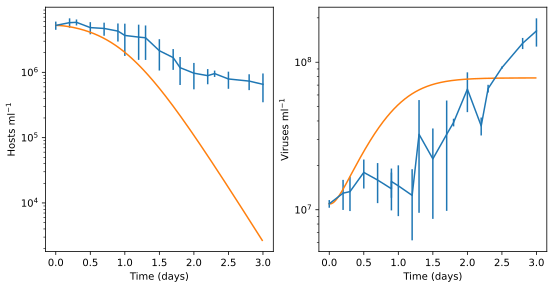

In [8]:
f,ax=modframe.plot()

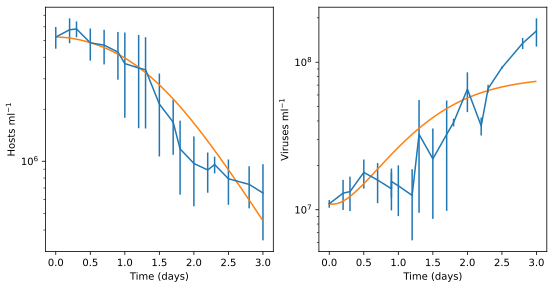

In [9]:
#for plotting purposes, lets grab the lowest chi to show the best fit we got
d=posteriors.loc[posteriors['chi'].idxmin()].to_dict()
f,ax=modframe.plot(**d)

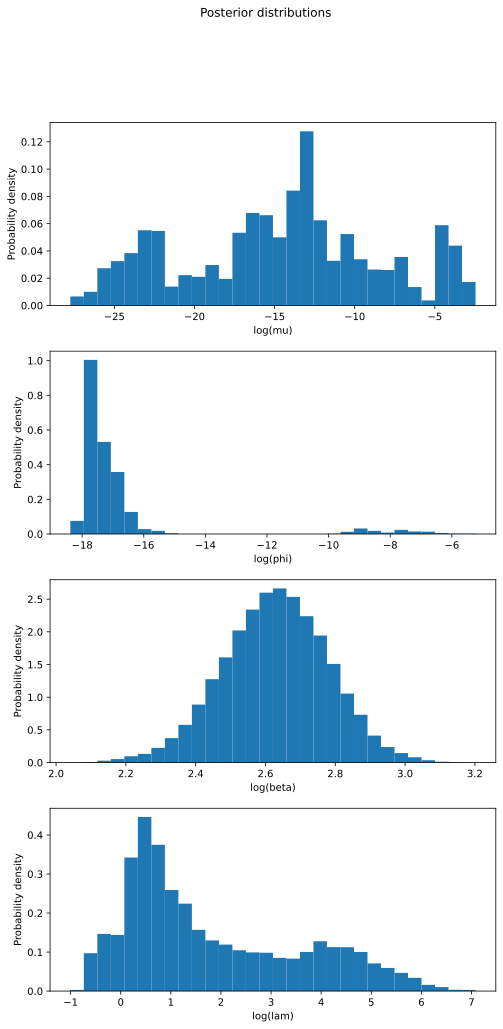

In [10]:
pnames = modframe.get_pnames()
dim = len(pnames)
f,ax = plt.subplots(dim,figsize=[dim*2,dim*4])
ax = ax.flatten()
for (a,p,i) in zip(ax,pnames,range(len(pnames))):
    a.hist(np.log(posteriors[p]),30,density=True)
    a.set_xlabel('log('+p+')')
    a.set_ylabel('Probability density')
f.suptitle('Posterior distributions')
f.subplots_adjust(hspace=0.25,wspace=0.25)    

## Results of 1 infection state

Our posterior distribuitons seem to be very large, indicicating this model is not well constrained.

The following cell will be a analysis of all models. Note that passing priors of unused parameters will not impact the analysis if there are not needed for the specified infection state

In [11]:
mu_prior = (6,3,True) # mean: 10^-6, mean - std: 10^-10, mean + std: 10^-2
phi_prior = (8,4,True)
beta_prior = (30,15,False)# normal distribution, mean = 30, sigma = 15.
lam_prior = (1,1,False)
tau_prior = (1,1,False)
#lets make a dictionary storing our frameworks
imod = {}
posteriors = list()
for i in range(0,6):
    print("Starting procedure for {} infection states".format(i))
    imod[i] = SnI(df,Infection_states=i)
    inits=imod[i].search_inits(samples=10000,cpu_cores=8,
                            mu=mu_prior,
                            phi=phi_prior,
                            beta=beta_prior,
                            lam=lam_prior,
                            tau = tau_prior
                           )
    #next line will raise error if there are not inits to sample, this means priors are too restrictive
    MCMC_inits = inits[inits['chi'] < 140].sample(20)
    posterior_istate=imod[i].MCMC(chain_inits = MCMC_inits,iterations=10000,cpu_cores=8)
    posterior_istate['Istates'] = i
    posteriors.append(posterior_istate)
    print("="*80)
posteriors = pd.concat(posteriors)

Starting procedure for 0 infection states
Sampling with a Latin Hypercube scheme
Starting 10000 processes with 8 cores	[DONE]
Starting 20 processes with 8 cores	[DONE]

Fitting Report
parameter: mu
	median = 4.931e-08, Standard deviation = 2.648e+15
parameter: phi
	median = 1.864e-08, Standard deviation = 2.919e-09
parameter: beta
	median = 1.316e+01, Standard deviation = 2.320e+00
Median parameter fit stats:
	Chi = 1.241e+01
	Adjusted R-squared = 4.610e-01
	AIC = 3.082e+01
Starting procedure for 1 infection states
Sampling with a Latin Hypercube scheme
Starting 10000 processes with 8 cores	[DONE]
Starting 20 processes with 8 cores	[DONE]

Fitting Report
parameter: mu
	median = 8.679e-07, Standard deviation = 4.891e+08
parameter: phi
	median = 1.186e-07, Standard deviation = 8.979e-06
parameter: beta
	median = 1.373e+01, Standard deviation = 2.341e+00
parameter: lam
	median = 1.184e+00, Standard deviation = 5.020e-01
Median parameter fit stats:
	Chi = 1.634e+01
	Adjusted R-squared = 4.

##### We will now try and integrate with the median paramters from each posterior distribution

{'Chi': 12.41115446736453, 'AdjR^2': 0.46101687709935024, 'AIC': 30.82230893472906}


(<Figure size 648x324 with 2 Axes>,
 array([<AxesSubplot:xlabel='Time (days)', ylabel='Hosts ml$^{-1}$'>,
        <AxesSubplot:xlabel='Time (days)', ylabel='Viruses ml$^{-1}$'>],
       dtype=object))

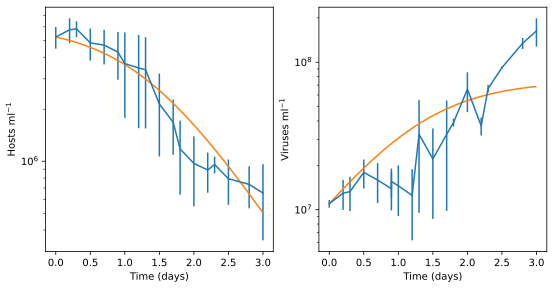

In [12]:
print(imod[0].get_fitstats())
imod[0].plot()

{'Chi': 16.338230594831114, 'AdjR^2': 0.42209759536061064, 'AIC': 40.67646118966223}


(<Figure size 648x324 with 2 Axes>,
 array([<AxesSubplot:xlabel='Time (days)', ylabel='Hosts ml$^{-1}$'>,
        <AxesSubplot:xlabel='Time (days)', ylabel='Viruses ml$^{-1}$'>],
       dtype=object))

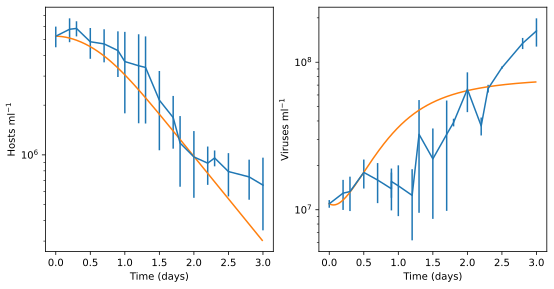

In [13]:
print(imod[1].get_fitstats())
imod[1].plot()

{'Chi': nan, 'AdjR^2': nan, 'AIC': nan}
Unable to print model preditions, integration failed


(<Figure size 648x324 with 2 Axes>,
 array([<AxesSubplot:xlabel='Time (days)', ylabel='Hosts ml$^{-1}$'>,
        <AxesSubplot:xlabel='Time (days)', ylabel='Viruses ml$^{-1}$'>],
       dtype=object))

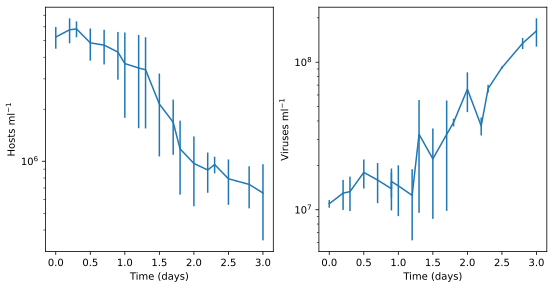

In [14]:
print(imod[2].get_fitstats())
imod[2].plot()

{'Chi': nan, 'AdjR^2': nan, 'AIC': nan}
Unable to print model preditions, integration failed


(<Figure size 648x324 with 2 Axes>,
 array([<AxesSubplot:xlabel='Time (days)', ylabel='Hosts ml$^{-1}$'>,
        <AxesSubplot:xlabel='Time (days)', ylabel='Viruses ml$^{-1}$'>],
       dtype=object))

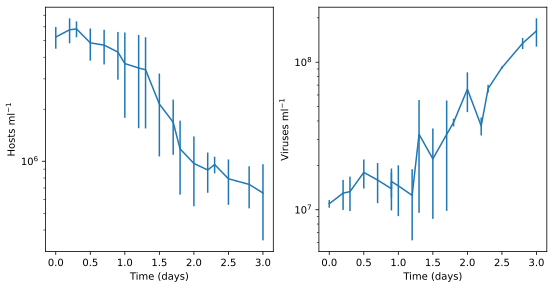

In [15]:
print(imod[3].get_fitstats())
imod[3].plot()

{'Chi': nan, 'AdjR^2': nan, 'AIC': nan}
Unable to print model preditions, integration failed


(<Figure size 648x324 with 2 Axes>,
 array([<AxesSubplot:xlabel='Time (days)', ylabel='Hosts ml$^{-1}$'>,
        <AxesSubplot:xlabel='Time (days)', ylabel='Viruses ml$^{-1}$'>],
       dtype=object))

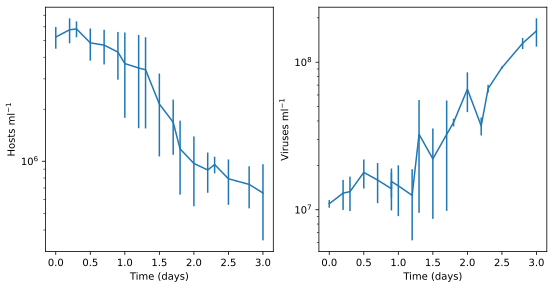

In [16]:
print(imod[4].get_fitstats())
imod[4].plot()

{'Chi': 297.75709386515126, 'AdjR^2': -0.3153635940324435, 'AIC': 611.5141877303025}


(<Figure size 648x324 with 2 Axes>,
 array([<AxesSubplot:xlabel='Time (days)', ylabel='Hosts ml$^{-1}$'>,
        <AxesSubplot:xlabel='Time (days)', ylabel='Viruses ml$^{-1}$'>],
       dtype=object))

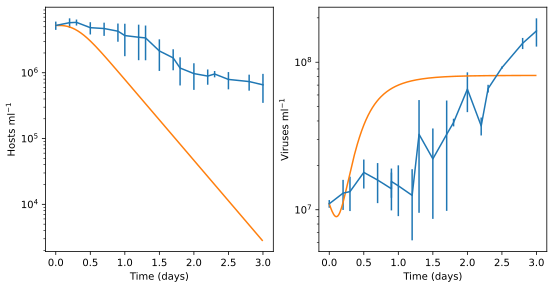

In [17]:
print(imod[5].get_fitstats())
imod[5].plot()